<a href="https://colab.research.google.com/github/arifcanaksoy/LSTM-Time-Series-Forecasting/blob/master/mult_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import os

import time
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.layers import Dropout
from keras.layers.core import Dense, Activation, Dropout
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

__INTRODUCTION__ <br><br>

LSTM model is one of the most efficient on Time Series. As in our problem, here we picked the models demonstrated multivariate, which incorporates multiple columns, and univariate one to yield a forecast with a good quality. With that said, in details two approaches is explained in the following sections and at the end `multivariate` model is favoured for the problem being adressed.

**Long Short-Term Memory Network - LSTM**


The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.


A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained. <br></br>

![LSTM](https://miro.medium.com/max/770/1*0f8r3Vd-i4ueYND1CUrhMA.png)

<br>

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers. A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

To remember the concept, there are three types of gates within a unit:

*Forget Gate*: conditionally decides what information to throw away from the block. <br>
*Input Gate*: conditionally decides which values from the input to update the memory state.
*Output Gate*: conditionally decides what to output based on input and the memory of the block.
Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

Contents <br><br>

1. DATA INGESTION <br>
2. DATA PRE-PROCESSING <br>
3. BUILDING PIPELINE of MULTIVARIATE LSTM MODEL <br>
  3.1. LSTM Data Preparation with Multiple Fields <br>
  3.2. Train-Test Split <br>
  3.3. RNN Topology <br>
  3.4. Evaluation <br>
  3.5. Extraction of Predictions <br>
4. *BUILDING MODEL for UNIVARIATE LSTM* <br>
5. CONCLUSION

__1. DATA INGESTION__

As we use google Colab, before running the next chunk of code, mount your drive.
Note: put the dataset *pre-processed* as held in previous sessions into a folder namely **datathon** right under MyDrive.

In [ ]:
cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
cd datathon/

/content/drive/My Drive/datathon


In [ ]:
# Read in the location dataset
df = pd.read_csv("datathon.csv", sep=",")

Some necessary helper functions for the following steps;

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

__2. DATA PRE-PROCESSING__

In [ ]:
df["DATE"] = df["DATE"].astype(str)
df["DATE"] = pd.to_datetime(df['DATE'], format = '%m/%d/%Y')

df.index = df.DATE
df = df.drop(['DATE','Unnamed: 0'], axis=1)

In [ ]:
df = df.fillna(0)

Our dataframe ID will be instead, combination of Category and Location fields as we treat time series at this level.

In [ ]:
# new ID equalt to combination of two fields
df["COMBINATION"] = df["CATEGORIA"].astype(str) + " - " + df["LOCATION"].astype(str)

# redundant
df = df.drop(["CATEGORIA", "LOCATION", "ID"], axis=1)
df.head(3)

,SECTOR,SECCION,U,E,E1,E6601,E6602,E6603,E6604,E6605,V1,V6601,V6602,V6603,V6604,V6605,DN,DW,IT,SHL.T,target_variable_v,covid_total_cases,covid_new_cases,covid_total_deaths,covid_new_deaths,covid_total_cases_per_million,covid_new_cases_per_million,covid_total_deaths_per_million,covid_new_deaths_per_million,ibex_open,ibex_High,ibex_low,ibex_close,ibex_volume,unemplyment_rate_spain,tourism_base_data,tourism_annual_variation,tourism_year_to_date_data,tourism_accumulative_variation,CATEGORIA_NUMBER,LOCATION_ID,TAG,WEEK_ID,STPTC_Concat,STPTC_PastYearsAvg,STPTC_Increase_Week,STPTC_Avg_Incr_first_10_weeks_2020,STPTC_Base_Demand without COVID,STPTC_Avg_Incr_week13-24_2020,STPTC_Changed_demand_attributable_to_new_normal,STPTC_Corona impacted sales considering new demand,STPTC_Stockpilling,STPTC_Stockpilling_Percentage,Normalized_V,COMBINATION
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-28,ALIM. Y BEBIDAS,ALIM.SECA,103127.0,165736.0,23826.0,1417.0,10524.0,3718.0,6844.0,1324.0,74448.0,5440.0,35811.0,11848.0,18743.0,2606.0,100.0,100.0,901178.0,4319,464609.0,0,0,0,0,0.0,0.0,0.0,0.0,10864.0,11007.7002,10788.7002,10905.90039,1929817500,17.4,1164980,10.19,5212797,9.81,1,1,W2017021,1,1-1-1,0.0,0.00%,0.0,0.0,0.0,0.0,0.0,0.0,0.00%,464609.0,ACEITE - ES ORG H+S Andalucia
2017-05-28,ALIM. Y BEBIDAS,ALIM.SECA,123904.0,122515.0,5278.0,3.0,125.0,285.0,4119.0,745.0,4592.0,4.0,246.0,537.0,3192.0,613.0,100.0,100.0,2477719.0,4319,99857.0,0,0,0,0,0.0,0.0,0.0,0.0,10864.0,11007.7002,10788.7002,10905.90039,1929817500,17.4,1164980,10.19,5212797,9.81,3,1,W2017021,1,3-1-1,0.0,0.00%,0.0,0.0,0.0,0.0,0.0,0.0,0.00%,99857.0,ADITIVOS COCINA - ES ORG H+S Andalucia
2017-05-28,ALIM. Y BEBIDAS,ALIM.SECA,83060.0,40251.0,6336.0,569.0,619.0,2292.0,2754.0,102.0,18865.0,1721.0,1267.0,7254.0,8326.0,298.0,100.0,100.0,1947865.0,4319,145457.0,0,0,0,0,0.0,0.0,0.0,0.0,10864.0,11007.7002,10788.7002,10905.90039,1929817500,17.4,1164980,10.19,5212797,9.81,7,1,W2017021,1,7-1-1,0.0,0.00%,0.0,0.0,0.0,0.0,0.0,0.0,0.00%,145457.0,ALIMENTOS INFANTILES - ES ORG H+S Andalucia


In [ ]:
# convert stockpile KPI into numeric format
df["STPTC_Stockpilling_Percentage"] = df["STPTC_Stockpilling_Percentage"].str.replace('%', '')
df["STPTC_Stockpilling_Percentage"] = df["STPTC_Stockpilling_Percentage"].astype(float)

Due to time and computation bottleneck, for next iterations here we pick the `SECCION` which is our priority by filtering.

In [ ]:
#index = pd.date_range(start=df.first_valid_index(),freq='7D',periods=190)
#df.set_index(index)

In [ ]:
df.SECCION.unique()

array(['ALIM.SECA', 'BEBIDAS', 'CONSERVAS', 'LECHE Y BATIDOS',
       'DROGUERIA Y LIMPIEZA', 'PERFUMERIA E HIGIENE', 'CHARCUTERIA',
       'CONGELADOS', 'DERV.LACTEOS', 'PL. COCINADOS Y PRECOCINADOS',
       'QUESOS'], dtype=object)

In [ ]:
data = df[df["SECCION"].str.contains('BEBIDAS', na = False)]

In [ ]:
# remove unnecessary columns
data = data[["target_variable_v", "STPTC_Stockpilling_Percentage", "covid_total_cases",'ibex_volume','unemplyment_rate_spain','tourism_accumulative_variation',"COMBINATION"]]

Our approach is basically creating sub-dataframes by filtering each unique combination of *LOCATION* and *CATEGORIA*, and treating each sub timeseries separately by calling from the dictionary in which they are stored. In other words, we do not create and run the model for total dataset at once, considering different potential patterns per each location + category.

In [ ]:
#create unique list of names
UniqueNames = data.COMBINATION.unique()

In [ ]:
#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = data.loc[:][data.COMBINATION == key]

In [ ]:
DataFrameDict

{'AGUAS - ES ESPANA+EESS EESS+INDEP':             target_variable_v  ...                        COMBINATION
 DATE                           ...                                   
 2017-05-28           401317.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2017-06-04           406713.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2017-06-11           426387.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2017-06-18           474538.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2017-06-25           500633.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 ...                       ...  ...                                ...
 2020-05-17           257723.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2020-05-24           282275.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2020-05-31           304877.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2020-06-07           341700.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 2020-06-14           334863.0  ...  AGUAS - ES ESPANA+EESS EESS+INDEP
 
 [160 rows x 7 columns],
 'AGUAS - ES 

__3. BUILDING PIPELINE of MULTIVARIATE LSTM MODEL__

One example for application of LSTM model on timeseries `BATIDOS in Andalucia` region:

* 3.1 LSTM Data Preparation with Multiple Fields

Just to try our model with one combination of category, location: "CERVEZA", "ANDALUCIA" respectively.

In [ ]:
# remove field CATEGORIA, which was just for filtering - model cannot run on string
datats = DataFrameDict['CERVEZA - ES ORG H+S Andalucia']
datats = datats.drop(["COMBINATION"], axis=1)

Another important point is that which fields are taken into consideration. Apart from computational concerns (as we have plenty of fields from the original dataset and also added **external data sources** such as ibex_volume, tourism, unemployment, further *feature extractions* - our distinguishable `StockPile KPI`), the fields are picked by correlation matrix used in `Vector Autoregression attempt` (see the appendix) and also considering the matrix table generated by `Granger Causality`. As a result, 5 additional variates will be feeding our Multivariate model to obtain a forecast for our target variable that is `V`.

In [ ]:
# call necessary fields
datats = datats[["target_variable_v",	"STPTC_Stockpilling_Percentage", "covid_total_cases",	"ibex_volume",	"unemplyment_rate_spain",	"tourism_accumulative_variation"]]

* 3.2 Train-Test Split

30% of timeseries is allocated for test, and the rest will be for train which will have 0 idea about the target variable so to say.

In [ ]:
train_size = int(len(datats) * 0.7)
test_size = len(datats) - train_size
train, test = datats.iloc[0:train_size], datats.iloc[train_size:len(datats)]
print(len(train), len(test))

112 48


Here we apply Robust Scaler especially in order to treat spikes, outliers relatively harsher than MinMaxScalar.

In [ ]:
from sklearn.preprocessing import RobustScaler

# feature columns (not incuding our target variable)
f_columns = ["STPTC_Stockpilling_Percentage", "covid_total_cases",'ibex_volume','unemplyment_rate_spain','tourism_accumulative_variation']

f_transformer = RobustScaler()
#f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

In [ ]:
# transform target variable too

#V_transformer = MinMaxScaler(feature_range=(0, 1))
V_transformer = RobustScaler()
V_transformer = V_transformer.fit(train[['target_variable_v']])
train['target_variable_v'] = V_transformer.transform(train[['target_variable_v']])
test['target_variable_v'] = V_transformer.transform(test[['target_variable_v']])

Model looks one step previous will be looked at a time.

In [ ]:
time_steps = 1
# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.target_variable_v, time_steps)
X_test, y_test = create_dataset(test, test.target_variable_v, time_steps)

print(X_train.shape, y_train.shape)

(111, 1, 6) (111,)


* 3.3 RNN Topology:

We would like to underline that our preference is `Bidirectional LSTM` which is not learning only by looking at the history, also learns by *looking onwards*. *Looking back* parameter is 1, since no good results obtained by keeping it high. What is more, Dropout by 20% is applied in terms of regularization. Other than that, *mse* and *adam* as loss metric and optimizer in turn, which are pretty in common.


In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio multiple                  138240    
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
dense_11 (Dense)             multiple                  257       
Total params: 138,497
Trainable params: 138,497
Non-trainable params: 0
_________________________________________________________________


Here we begin training our model with the picked dataset to see if the model makes sense after all.

In [ ]:
# train the model
history = model.fit(
    X_train, y_train, 
    epochs=90,
    batch_size=75, 
    validation_split=0.2,
    shuffle=False
)

Epoch 1/90

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2/2 [==============================] - 1s 384ms/step - loss: 0.5394 - val_loss: 0.2404
Epoch 2/90
2/2 [==============================] - 0s 22ms/step - loss: 0.5200 - val_loss: 0.2366
Epoch 3/90
2/2 [==============================] - 0s 21ms/step - loss: 0.5005 - val_loss: 0.2332
Epoch 4/90
2/2 [==============================] - 0s 23ms/step - loss: 0.4877 - val_loss: 0.2301
Epoch 5/90
2/2 [==============================] - 0s 22ms/step - loss: 0.4776 - val_loss: 0.2272
Epoch 6/90
2/2 [======

* 3.4 Evaulation of the Model:

Just to mention, number of epochs as an important parameter is kept by 90 which looked enough as other options up to 180 are also tried but ended up just with *overfitting and computational loss*. Bath_size, how many data is seen at one iteration is preferred to adjust by *75* considering the time range we have with our dataset (from 2017, weekly until 2020). For evaluation of training phase, 0.2 of the training data is used for cross validation.

Here’s what we have after training our model for 90 epochs; train and test sets meet at a step and after that, we do not observe slight increase in loss measure of test set, which is the acceptable. RMSE is around 11.7% when performed **to the other categories**.

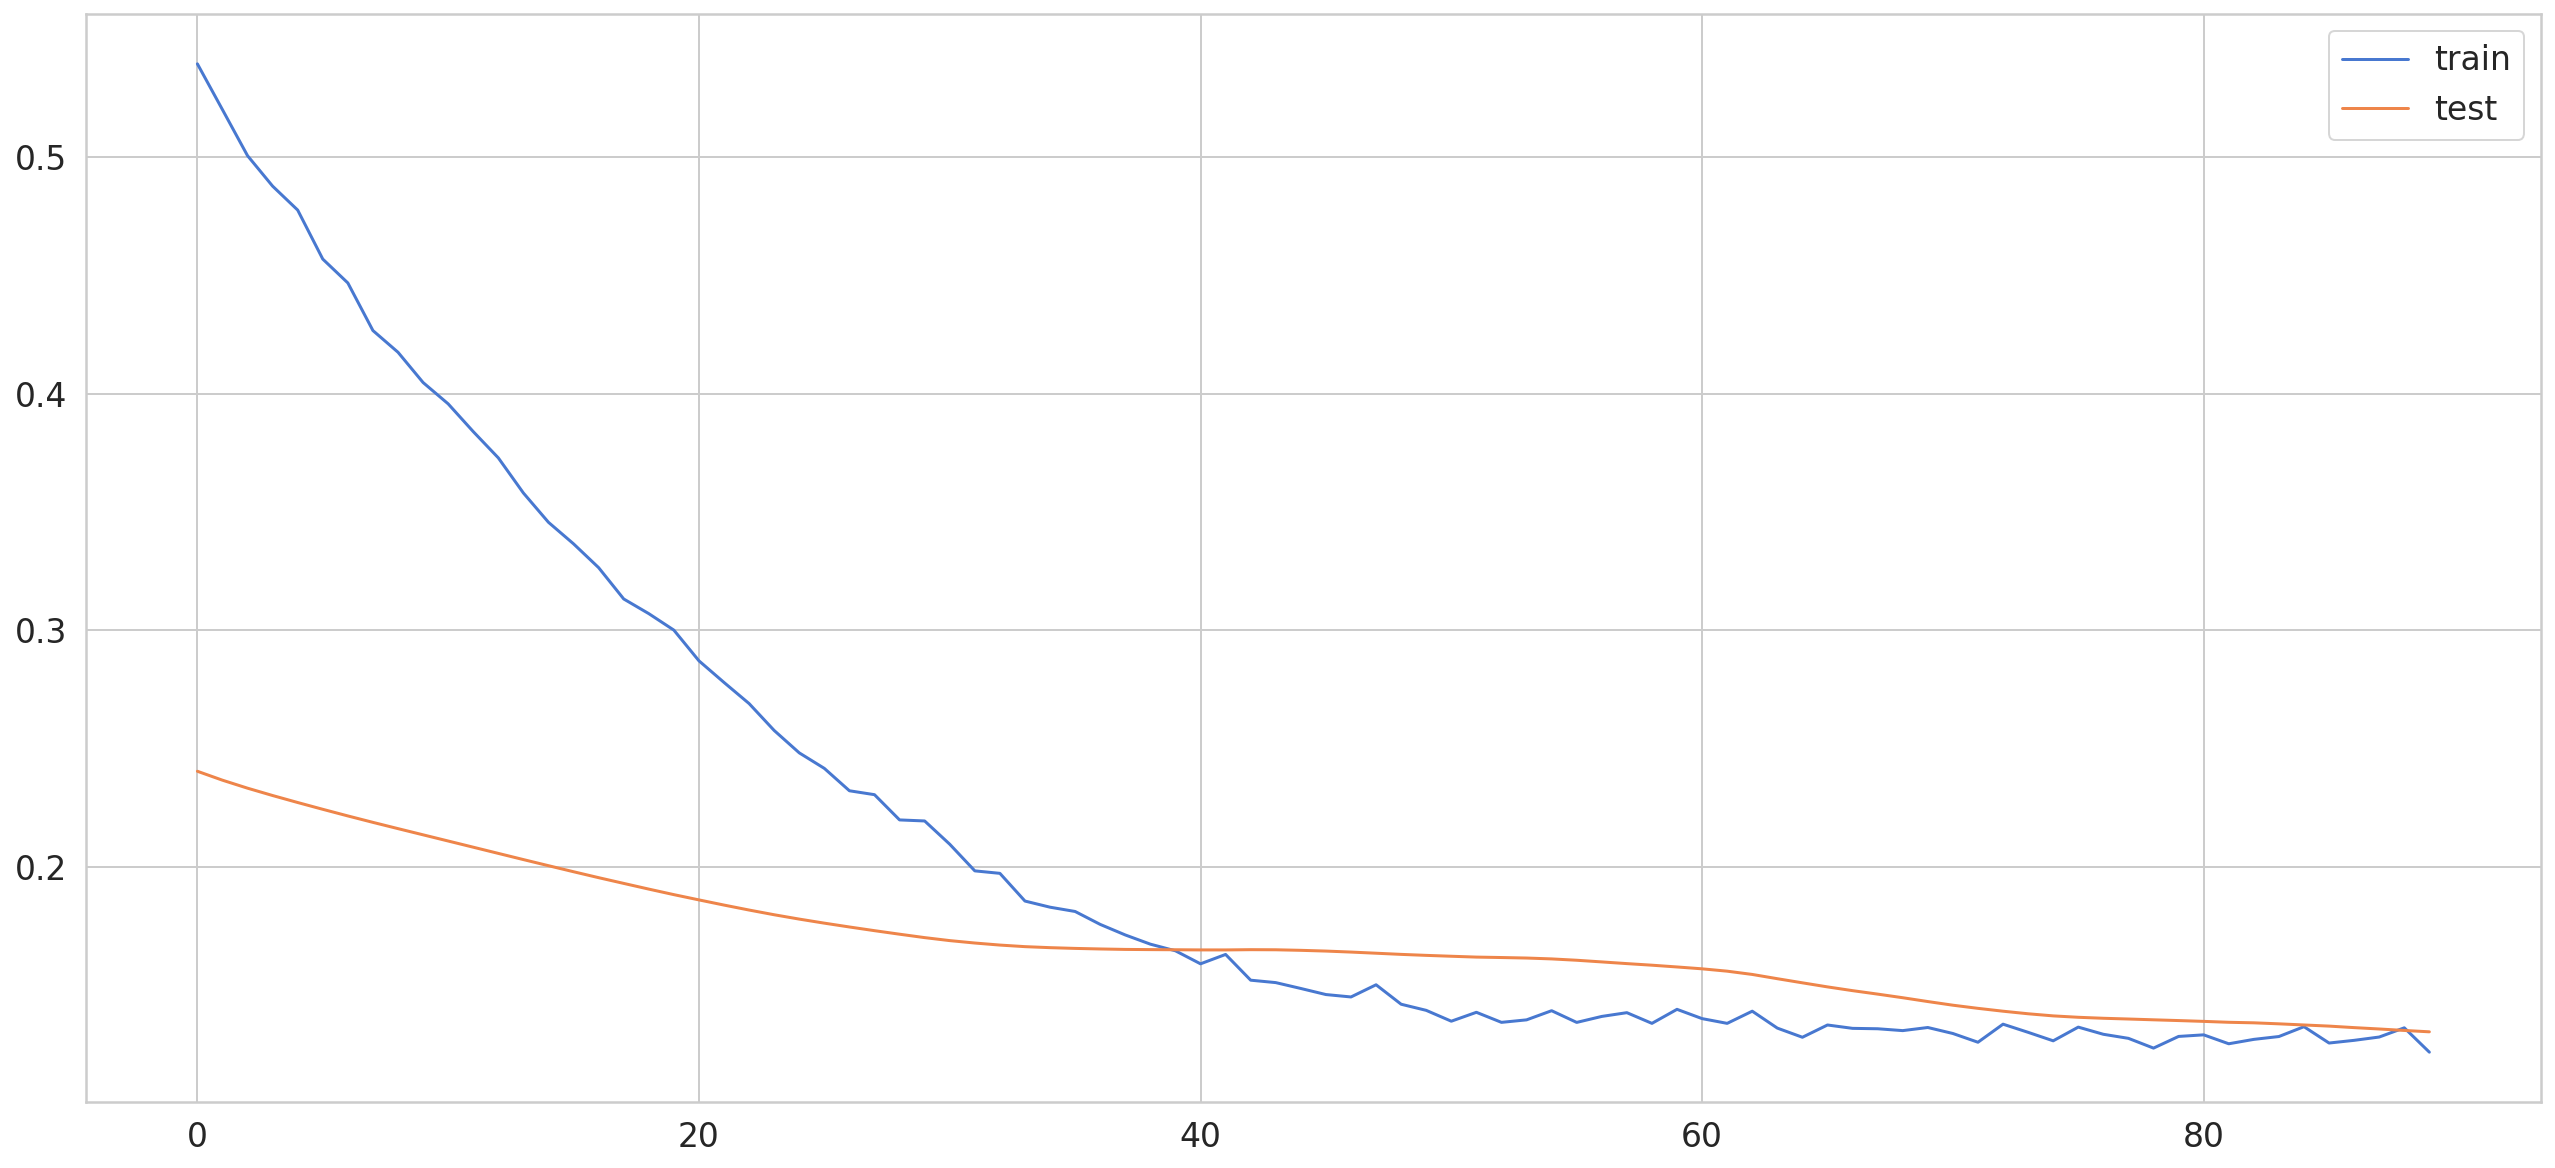

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
# predict via the model
y_pred = model.predict(X_test)
# inverse the predictions to real values
y_train_inv = V_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = V_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = V_transformer.inverse_transform(y_pred)

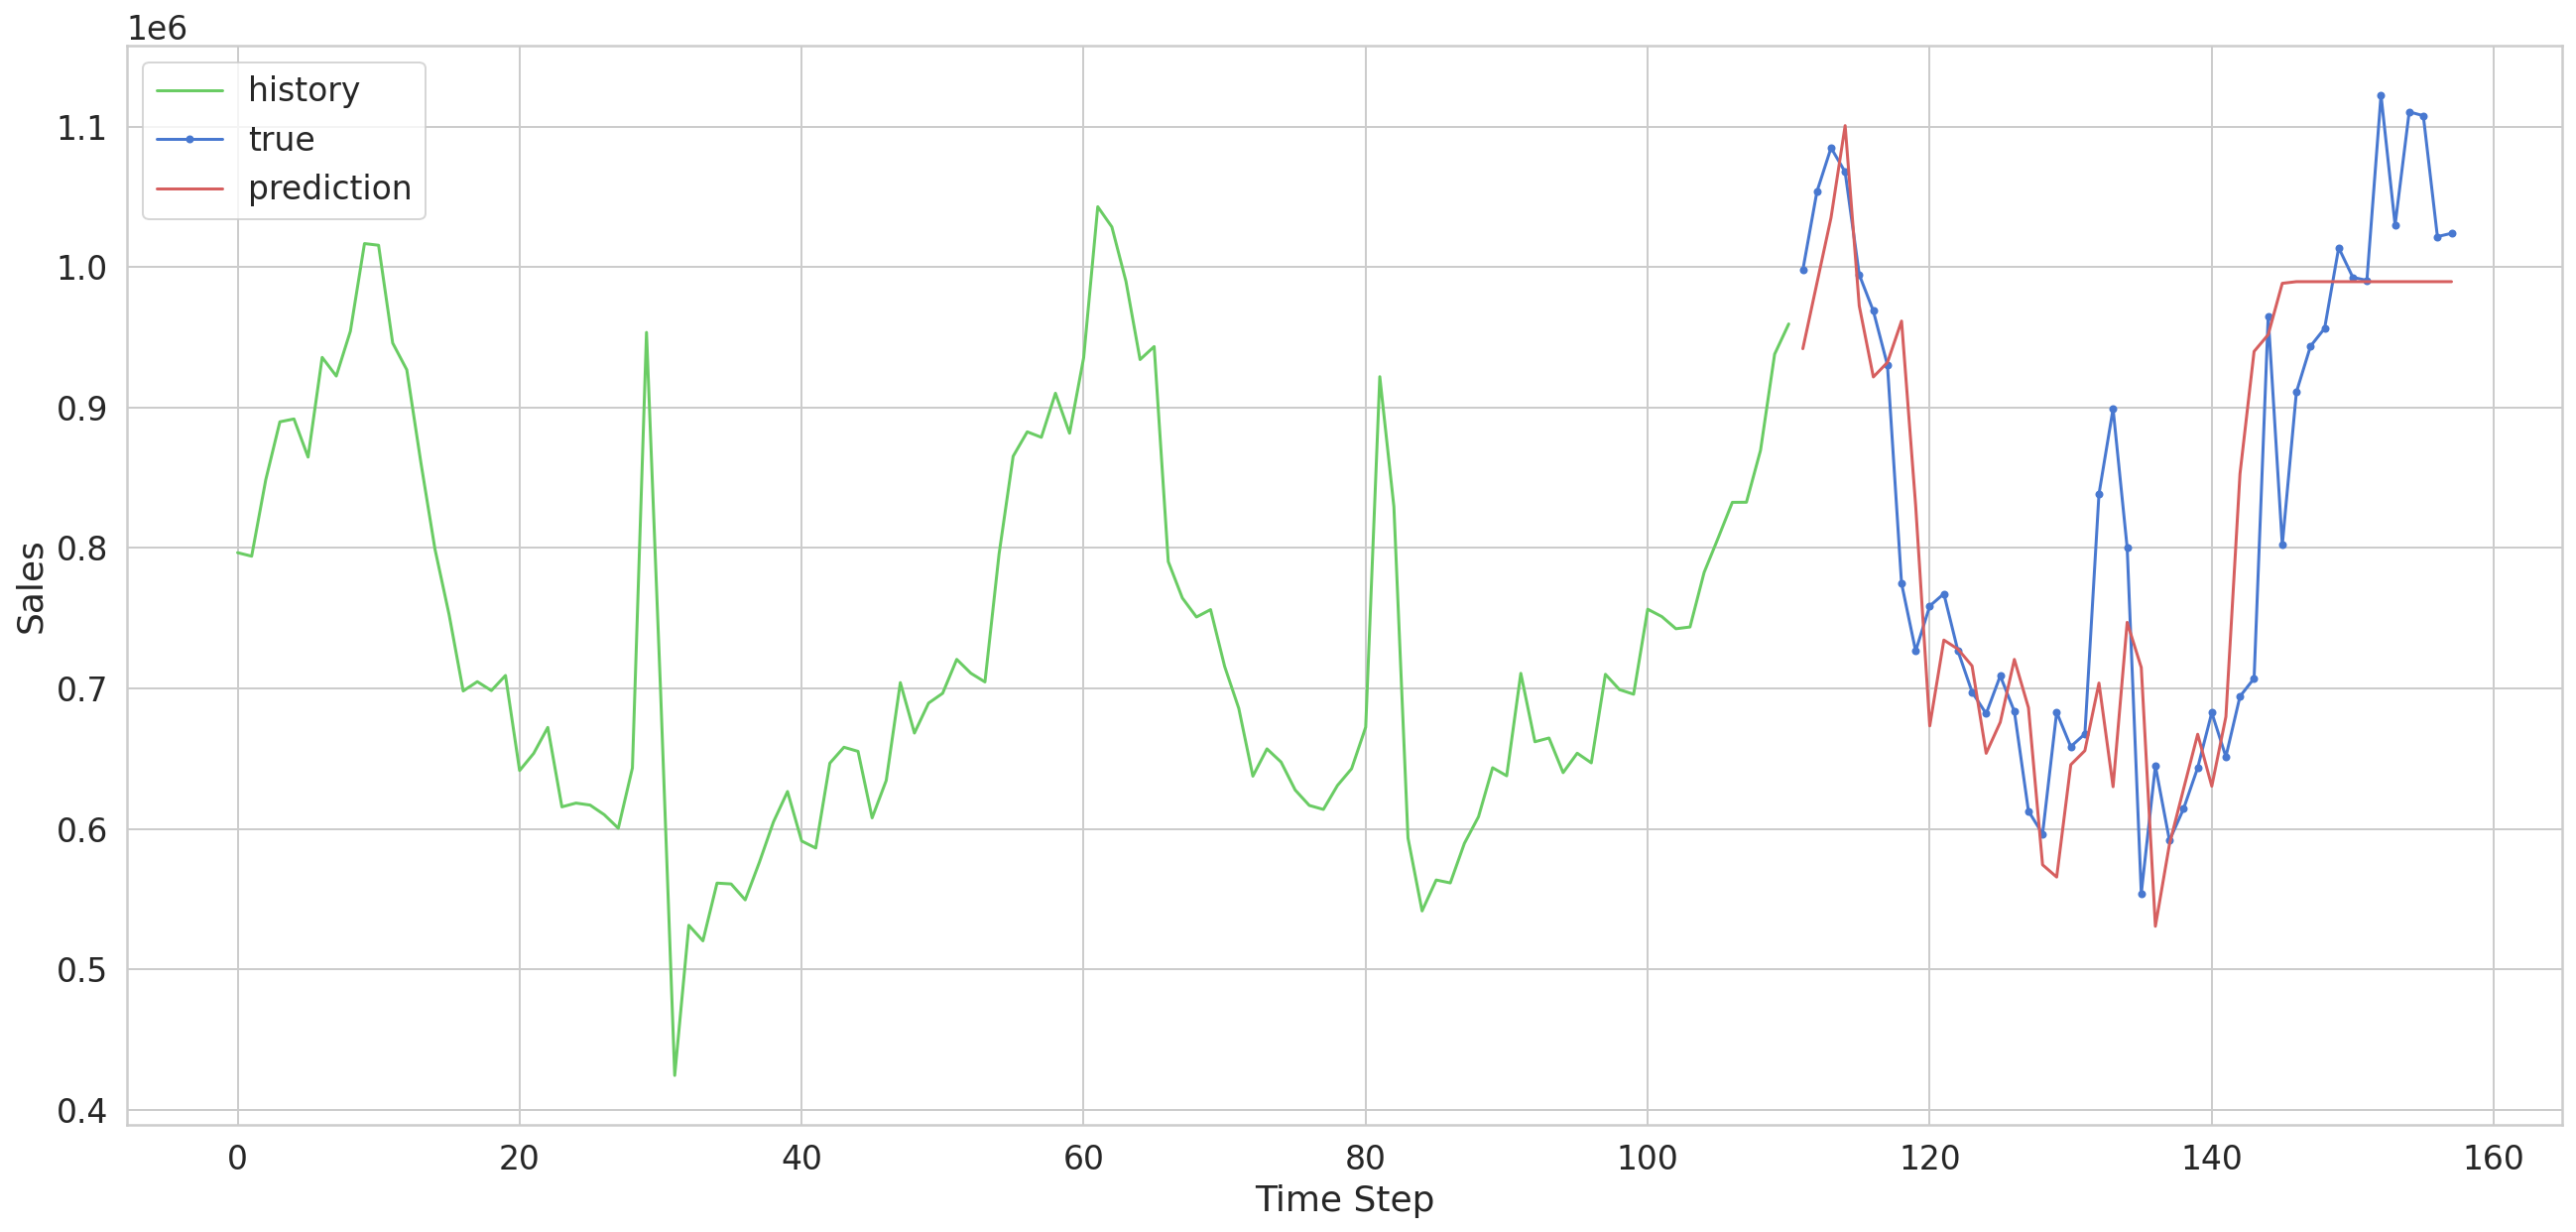

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Sales')
plt.xlabel('Time Step')
plt.legend()
plt.show();

As model performance is acceptable when looked at the graph above; let's make our forecast based on the model trained with full data then.

In [ ]:
train_size = int(len(datats) * 1)
train = datats

In [ ]:
f_columns = ["STPTC_Stockpilling_Percentage", "covid_total_cases",'ibex_volume','unemplyment_rate_spain','tourism_accumulative_variation']
f_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())

V_transformer = RobustScaler()
V_transformer = V_transformer.fit(train[['target_variable_v']])
train['target_variable_v'] = V_transformer.transform(train[['target_variable_v']])

In [ ]:
time_steps = 1
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.target_variable_v, time_steps)

In [ ]:
model.fit(
    X_train, y_train, 
    epochs=90, 
    batch_size=75, 
    shuffle=False, verbose =0
)

Here we obtain the prediction until end of year

In [ ]:
y_pred = model.predict(X_train)
y_pred_inv = V_transformer.inverse_transform(y_pred)

3.5. Extraction of Predictions <br>

Modeler helper function we built takes sub time-series dataset of combination and applies every necessary step and returns the predictions for following 30 weeks.

In [ ]:
# helper function to facilitate our prediction extraction
def modeler(data):
  train_size = int(len(data) * 1)
  train = data
  f_transformer = RobustScaler()

  V_transformer = RobustScaler()
  f_transformer = f_transformer.fit(train[f_columns].to_numpy())
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())

  V_transformer = V_transformer.fit(train[['target_variable_v']])
  train['target_variable_v'] = V_transformer.transform(train[['target_variable_v']])  
  
  X_train, y_train = create_dataset(train, train.target_variable_v, time_steps=1)

  model.fit(X_train, y_train, epochs=90, batch_size=75, shuffle=False, verbose=0)
  y_pred = model.predict(X_train)
  y_pred_inv = V_transformer.inverse_transform(y_pred)
  # get the predictions until the end of 2020, for 30 weeks onwards
  return(np.fromiter(y_pred_inv[:30], dtype=int))

Here we create an empty dataframe called *Predictions*, and for the picked combination model is trained per each timeseries. Ultimate result of predictions will be appended one by one throughout the for loop.

In [ ]:
  # empty dataframe
  Predictions = pd.DataFrame(columns=UniqueNames)

In [ ]:
for i in UniqueNames:
  datats = DataFrameDict[i]
  datats = datats.drop(["COMBINATION"], axis=1)
  Predictions[i] = modeler(datats)

In [ ]:
Predictions.head(2)

,ACEITE - ES ORG H+S Andalucia,ADITIVOS COCINA - ES ORG H+S Andalucia,ALIMENTOS INFANTILES - ES ORG H+S Andalucia,ALIMENTOS MASCOTAS - ES ORG H+S Andalucia,APERITIVOS - ES ORG H+S Andalucia,ARROZ - ES ORG H+S Andalucia,AZUCAR Y EDULCORANTES - ES ORG H+S Andalucia,BOLLERIA INDUSTRIAL - ES ORG H+S Andalucia,CACAO - ES ORG H+S Andalucia,CAFES - ES ORG H+S Andalucia,CEREALES DESAYUNO - ES ORG H+S Andalucia,CHOCOLATES - ES ORG H+S Andalucia,DIETETICOS - ES ORG H+S Andalucia,DULCES NAVIDENOS - ES ORG H+S Andalucia,FRUTOS SECOS - ES ORG H+S Andalucia,GALLETAS - ES ORG H+S Andalucia,GOLOSINAS - ES ORG H+S Andalucia,INFUSIONES - ES ORG H+S Andalucia,LEGUMBRES SECAS - ES ORG H+S Andalucia,PANADERIA INDUSTRIAL - ES ORG H+S Andalucia,PASTAS - ES ORG H+S Andalucia,REPOSTERIA - ES ORG H+S Andalucia,SALSAS - ES ORG H+S Andalucia,SOPAS Y DESHIDRATADOS - ES ORG H+S Andalucia,ACEITE - ES ORG H+S Aragon,ADITIVOS COCINA - ES ORG H+S Aragon,ALIMENTOS INFANTILES - ES ORG H+S Aragon,ALIMENTOS MASCOTAS - ES ORG H+S Aragon,APERITIVOS - ES ORG H+S Aragon,ARROZ - ES ORG H+S Aragon,AZUCAR Y EDULCORANTES - ES ORG H+S Aragon,BOLLERIA INDUSTRIAL - ES ORG H+S Aragon,CACAO - ES ORG H+S Aragon,CAFES - ES ORG H+S Aragon,CEREALES DESAYUNO - ES ORG H+S Aragon,CHOCOLATES - ES ORG H+S Aragon,DIETETICOS - ES ORG H+S Aragon,DULCES NAVIDENOS - ES ORG H+S Aragon,FRUTOS SECOS - ES ORG H+S Aragon,GALLETAS - ES ORG H+S Aragon,...,CACAO - ES ESPANA+EESS EESS+INDEP,CAFES - ES ESPANA+EESS EESS+INDEP,CEREALES DESAYUNO - ES ESPANA+EESS EESS+INDEP,CHOCOLATES - ES ESPANA+EESS EESS+INDEP,DIETETICOS - ES ESPANA+EESS EESS+INDEP,DULCES NAVIDENOS - ES ESPANA+EESS EESS+INDEP,FRUTOS SECOS - ES ESPANA+EESS EESS+INDEP,GALLETAS - ES ESPANA+EESS EESS+INDEP,GOLOSINAS - ES ESPANA+EESS EESS+INDEP,INFUSIONES - ES ESPANA+EESS EESS+INDEP,LEGUMBRES SECAS - ES ESPANA+EESS EESS+INDEP,PANADERIA INDUSTRIAL - ES ESPANA+EESS EESS+INDEP,PASTAS - ES ESPANA+EESS EESS+INDEP,REPOSTERIA - ES ESPANA+EESS EESS+INDEP,SALSAS - ES ESPANA+EESS EESS+INDEP,SOPAS Y DESHIDRATADOS - ES ESPANA+EESS EESS+INDEP,ACEITE - ES ESPANA+EESS PERFUMERIAS,ADITIVOS COCINA - ES ESPANA+EESS PERFUMERIAS,ALIMENTOS INFANTILES - ES ESPANA+EESS PERFUMERIAS,ALIMENTOS MASCOTAS - ES ESPANA+EESS PERFUMERIAS,APERITIVOS - ES ESPANA+EESS PERFUMERIAS,ARROZ - ES ESPANA+EESS PERFUMERIAS,AZUCAR Y EDULCORANTES - ES ESPANA+EESS PERFUMERIAS,BOLLERIA INDUSTRIAL - ES ESPANA+EESS PERFUMERIAS,CACAO - ES ESPANA+EESS PERFUMERIAS,CAFES - ES ESPANA+EESS PERFUMERIAS,CEREALES DESAYUNO - ES ESPANA+EESS PERFUMERIAS,CHOCOLATES - ES ESPANA+EESS PERFUMERIAS,DIETETICOS - ES ESPANA+EESS PERFUMERIAS,DULCES NAVIDENOS - ES ESPANA+EESS PERFUMERIAS,FRUTOS SECOS - ES ESPANA+EESS PERFUMERIAS,GALLETAS - ES ESPANA+EESS PERFUMERIAS,GOLOSINAS - ES ESPANA+EESS PERFUMERIAS,INFUSIONES - ES ESPANA+EESS PERFUMERIAS,LEGUMBRES SECAS - ES ESPANA+EESS PERFUMERIAS,PANADERIA INDUSTRIAL - ES ESPANA+EESS PERFUMERIAS,PASTAS - ES ESPANA+EESS PERFUMERIAS,REPOSTERIA - ES ESPANA+EESS PERFUMERIAS,SALSAS - ES ESPANA+EESS PERFUMERIAS,SOPAS Y DESHIDRATADOS - ES ESPANA+EESS PERFUMERIAS
0,501170,102092,151989,240216,249555,64931,61300,348370,105340,293093,110254,220412,66520,8478,270957,290543,115702,51296,46354,298882,93607,21252,270954,195832,77330,18134,10886,34730,37492,11126,10621,59441,18259,51240,19075,39551,13348,2594,45955,55286,...,42215,115936,15059,170484,14135,1515,100818,208101,200676,13484,35426,121556,57999,11419,73040,68936,11,39,24566,68754,1047,-5,265,214,177,4139,785,6155,57084,-6,580,4454,7316,1139,-2,192,1,12,2,0
1,513638,105525,146319,238862,250042,62840,59496,336582,105011,280374,108370,174063,63982,2949,269723,287231,116722,48797,42893,294271,89188,18017,264132,190571,78355,17878,10051,34375,38169,10587,10592,59709,18637,50389,18730,36764,12864,2537,46840,55362,...,41223,114245,14575,154071,13327,1415,95949,204512,194985,13771,35603,123837,57674,9018,75656,71715,161,156,23324,65961,1030,-12,231,227,155,3830,681,5389,55177,53,600,3890,7130,1090,2,230,4,9,-13,0


In [ ]:
# writing the prediction for picked Seccion to a .csv file
Predictions.to_csv("predictions-QUESOS.csv",  index=False)

In [ ]:
#create a data frame dictionary to store your data frames
PredictionsDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df.loc[:][df.ID == key]

In [ ]:
Predictions = pd.DataFrame(columns=UniqueNames)

<br><br>
**4. BUILDING MODEL for UNIVARIATE LSTM**

Even though we rely on the Multivariate LSTM, still we have given a chance to this approach as well. Univariate model takes into consideration `single field`, which is the *target variable*.


Note: Preparing the 3D input vector for the LSTM. Remember, the input vector for LSTM is 3D array: (num_samples, num_time_steps, num_features). In this case we have num of time steps = 50 and num_features = 1

In [ ]:
# we will be looking at the data by windows of 12 weeks-length 
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [ ]:
# Build the model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit_generator(generator,epochs=180)

Epoch 1/180
23/23 [==============================] - 1s 31ms/step - loss: 0.0928
Epoch 2/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0351
Epoch 3/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0303
Epoch 4/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0293
Epoch 5/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0332
Epoch 6/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0269
Epoch 7/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0284
Epoch 8/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0248
Epoch 9/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0262
Epoch 10/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0232
Epoch 11/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0276
Epoch 12/180
23/23 [==============================] - 0s 19ms/step - loss: 0.0257
Epoch 13/180
23/23 [=====

In [ ]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [ ]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=data[-n_input:].index, columns=['Prediction'])

df_test = pd.concat([data,df_predict], axis=1)

In [ ]:
df_test.tail()

,target_variable_v,Prediction
DATE,,
2020-05-17,1029864.0,9.767481e+05
2020-05-24,1110461.0,1.010527e+06
2020-05-31,1107709.0,1.021860e+06
2020-06-07,1021616.0,9.789781e+05
2020-06-14,1023992.0,1.021958e+06


Indeed, this overlooked model performs pretty well on the train dataset as seen below the prediction (red-line) flows parallel to the actual (blue)

No handles with labels found to put in legend.


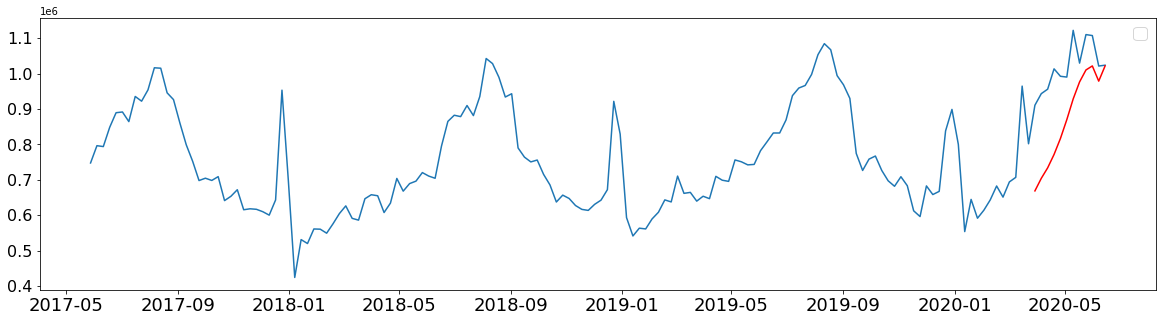

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['target_variable_v'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
pred_actual_rmse = rmse(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
print("rmse: ", pred_actual_rmse)

rmse:  [165464.0288206]


In [ ]:
train = data

In [ ]:
scaler.fit(train)
train = scaler.transform(train)

In [ ]:
# by looking back 12 weeks
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [ ]:
model.fit_generator(generator,epochs=180)

Epoch 1/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0095
Epoch 2/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0106
Epoch 3/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0090
Epoch 4/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0085
Epoch 5/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0116
Epoch 6/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0091
Epoch 7/180
25/25 [==============================] - 0s 18ms/step - loss: 0.0091
Epoch 8/180
25/25 [==============================] - 0s 18ms/step - loss: 0.0082
Epoch 9/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0104
Epoch 10/180
25/25 [==============================] - 0s 18ms/step - loss: 0.0093
Epoch 11/180
25/25 [==============================] - 0s 19ms/step - loss: 0.0084
Epoch 12/180
25/25 [==============================] - 0s 18ms/step - loss: 0.0087
Epoch 13/180
25/25 [=====

In [ ]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [ ]:
from pandas.tseries.offsets import DateOffset
add_dates = [data.index[-1] + DateOffset(month=x) for x in range(0,13) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=data.columns)

In [ ]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([data,df_predict], axis=1)

This is the forecast of the model, after the model is trained with whole dataset (160 weeks). It signals some decline in sales which is plausible after all panic buying epoch.

No handles with labels found to put in legend.


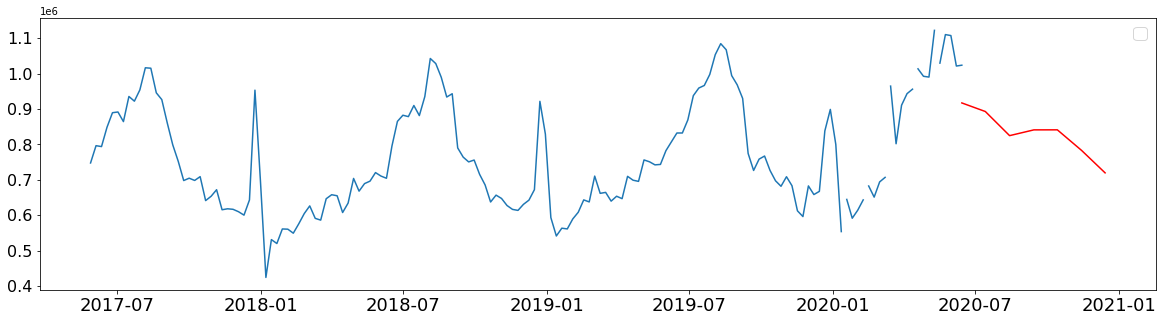

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['target_variable_v'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

**5. CONCLUSION** <br>

As explained step by step how two different LSTM approaches are applied, metrics pointed out Multivariate model outperformed the Univariate by 3% lower error. Its consideration of more than just target variable as a favouring apriori validated on a considerable extent by checking final outputs as well. Therefore, our preference has ended up with Multivariate LSTM, thus final predictions for complete dataset is obtained according to this pipeline. To wrap up with further improvements, categorization of variables, further K-Means clustering and scrutinizing more on Hyperparameter tuning, or more importantly if we were able to combine VAR with LSTSM, all these could have yielded our analysis slightly more sophistication and accuracy even though the boldness of the problem when the volatility of times we undergo is obvious.

* ACKNOWLEDGEMENTS

[A Quick Example of Time-Series Prediction Using Long Short-Term Memory (LSTM) Networks](https://medium.com/swlh/a-quick-example-of-time-series-forecasting-using-long-short-term-memory-lstm-networks-ddc10dc1467d)

[Time Series Prediction with LSTMs using TensorFlow 2 and Keras in Python](https://www.youtube.com/watch?v=xaIA83x5Icg)

[How to Develop LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)